In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import  train_test_split
import copy
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
failures = pd.read_csv('../data/model_data/failures.csv',sep=',')
components = failures['Component'].unique()

In [3]:
encoder = LabelEncoder()
for component in components:
    globals()[f"{component}_df"] = pd.read_csv(f'../data/model_data/labelled_data_{component}.csv',sep=',')
    globals()[f"{component}_df"]['Turbine_ID'] = encoder.fit_transform(['Turbine_ID']*globals()[f"{component}_df"].shape[0])
    # set the date as the index
    globals()[f"{component}_df"] = globals()[f"{component}_df"].set_index('Timestamp')

In [4]:
class_target_name = "Failure (Target)"
for component in components:
    X = globals()[f"{component}_df"].drop(columns=['Component',class_target_name])
    y = globals()[f"{component}_df"][class_target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    globals()[f"{component}_X_train"] = X_train
    globals()[f"{component}_X_test"] = X_test
    globals()[f"{component}_y_train"] = y_train
    globals()[f"{component}_y_test"] = y_test

In [5]:
model_name = "xgb"

In [66]:

for component in components:

    with open("./model/{}_{}.pickle".format(model_name, component), "rb") as f:
        globals()[f"{model_name}_{component}"] = pickle.load(f)

In [67]:
def train_runs_XGB(X_train, y_train, model):
    clf = ExtraTreesClassifier(n_estimators=50)
    tree_selector = SelectFromModel(clf)
   
    base_estimator = model
    base_estimator.steps.insert(-1, ["selector", tree_selector])
    param_grid = {

        "selector__max_features": Integer(5, 100),
        "{}__max_depth".format(model_name): [10, 20, 40, 80],
        "{}__n_estimators".format(model_name): [50, 100, 200],
        "{}__learning_rate".format(model_name): Real(0.01, 0.2, prior='log-uniform')

    }
    bayes_search = BayesSearchCV(
        estimator=base_estimator,
        search_spaces=param_grid,
        scoring="f1_weighted",
        n_iter=50,
        cv=5,
        verbose=2,
        random_state=0,
        n_jobs=-1
    )

    bayes_search.fit(X_train, y_train)
    results = bayes_search.cv_results_
    best_clf = bayes_search.best_estimator_

    return best_clf, results, param_grid

In [ ]:
best_clf, results, param_grid = train_runs_XGB(GEARBOX_X_train, GEARBOX_y_train, xgb_GEARBOX)

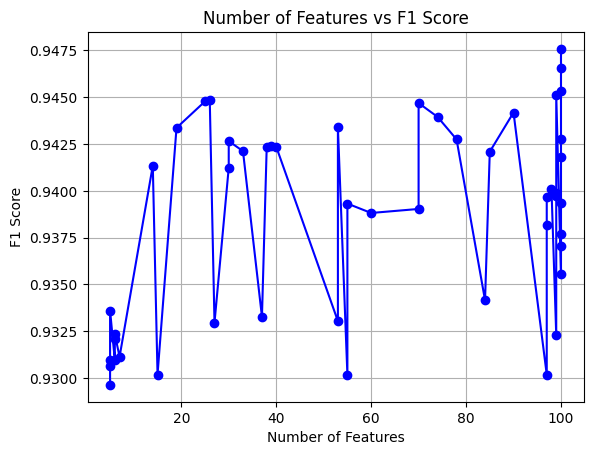

In [91]:
# sort the number of features and their performance
def plot_feature_performance(results, param_grid):
    fig, ax = plt.subplots()
    max_features_list = [results["params"][i]["selector__max_features"] for i in range(len(results["params"]))]
    scores = [results["mean_test_score"][i] for i in range(len(results["mean_test_score"]))]

    max_features_list, scores = zip(*sorted(zip(max_features_list, scores)))
    ax.plot(max_features_list, scores, marker='o', color='blue', linestyle='-')
    
    ax.set_xlabel("Number of Features")
    ax.set_ylabel("F1 Score")
    ax.set_title("Number of Features vs F1 Score")
    plt.grid(True)
    plt.show()
plot_feature_performance(results, param_grid)

In [88]:
# print number offeature with highest performance
def get_best_features(results):
    best_score = max(results["mean_test_score"])
    best_index = results["mean_test_score"].tolist().index(best_score)
    best_features = results["params"][best_index]["selector__max_features"]
    return best_features

In [92]:
get_best_features(results)

100

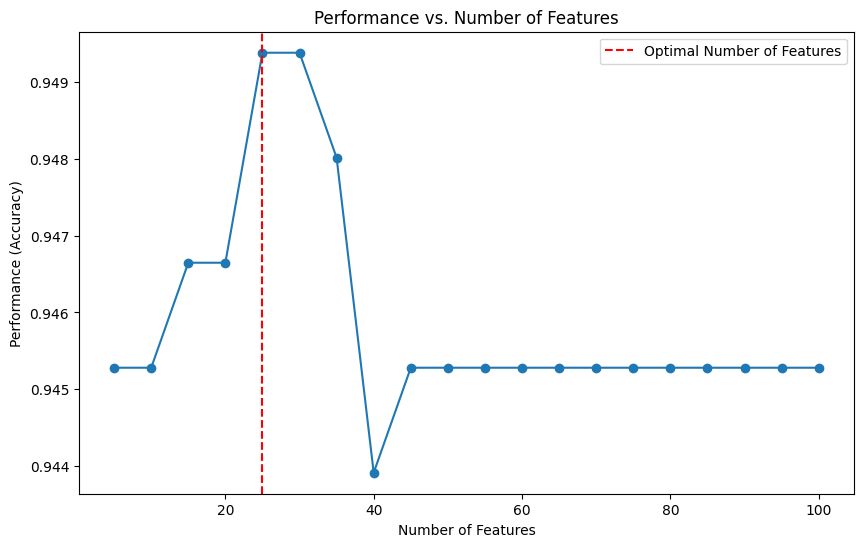

In [156]:
plt.figure(figsize=(10, 6))
plt.plot(num_features, performances, marker='o')
plt.title('Performance vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Performance (Accuracy)')
plt.axvline(x=num_features[performances.index(max(performances))], linestyle='--', color='r', label='Optimal Number of Features')
plt.legend()
plt.show()